# Imports

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import optim
import torch.nn as nn

import tqdm

# ---
import sys; sys.path.append('../')

from commons.imgs_mean_std import *

from commons.dataset import *
from commons.imageutils import *
from commons.HistCollection import *

from modules.img_transforms import *
from modules.train_functions import *
from modules.Comparator import *

from modules.Dataset import *
from modules.EarlyStopper import *

from modules.Model import *

# Constants & hyperparams

In [2]:
RANDOM_STATE=None

IMAGE_SIZE=220

BATCH_SIZE=32
NUM_EPOCHS=100

LEARNING_RATE=.001
MOMENTUM=.9

EARLY_PATIENCE=10
SCHEDULER_PATIENCE=6

# CUDA

In [3]:
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if device == 'cuda':
    print(torch.cuda.is_available())
    print(torch.cuda.get_device_name(0))
    print('Devices: ', torch.cuda.device_count())

2.2.2
Device: cpu


# Loading datasets

In [4]:
train_dataset = pd.read_csv(os.path.join(DATASETS_PATHS.norm_faces.info, 'train_dataset.csv'))
val_dataset = pd.read_csv(os.path.join(DATASETS_PATHS.norm_faces.info, 'val_dataset.csv'))
test_dataset = pd.read_csv(os.path.join(DATASETS_PATHS.norm_faces.info, 'test_dataset.csv'))

# Creating custom datasets

In [5]:
normalization= normalize(IMAGE_SIZE, MEAN, STD)

train_dataset = CD_TrippletsCreator(train_dataset, transform=normalization, data_augmentation_tranforms=[data_augmentation()])
val_dataset = CD_TrippletsCreator(val_dataset, transform=normalization)
test_dataset = CD_TrippletsCreator(test_dataset, transform=normalization)

# Dataloaders

In [6]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, drop_last=True)

# Early stopping

In [7]:
def early_callback(**kwarks):
    print(" > Early Stop <")

early_stopper = EarlyStopper(EARLY_PATIENCE, .001, callback=early_callback)

# Loading model

In [8]:
model = Model()
if device == 'cuda' and torch.cuda.device_count() > 1: model = nn.DataParallel(model)

model.to(device)

Model(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 512, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runn

# Defining tools

In [9]:
criterion = nn.TripletMarginLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=.2, patience=SCHEDULER_PATIENCE, verbose=True)

/Users/student/.conda/envs/vc_project/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


# Training

100%|██████████| 14/14 [14:29<00:00, 62.11s/it]


TypeError: eval() missing 1 required keyword-only argument: 'dst'

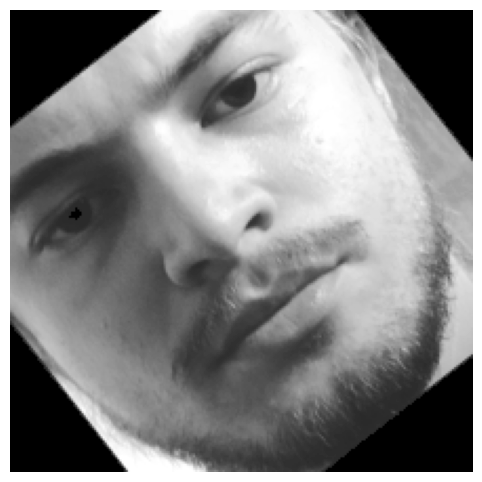

In [10]:
def callback(**kwargs):

    train_posit_mean_h = [np.mean(elm) for elm in  kwargs['train_h'].posit_dst]
    train_negat_mean_h = [np.mean(elm) for elm in  kwargs['train_h'].negat_dst]

    val_posit_mean_h = [np.mean(elm) for elm in  kwargs['val_h'].posit_dst]
    val_negat_mean_h = [np.mean(elm) for elm in  kwargs['val_h'].negat_dst]


    print(f"Epoch: {kwargs['epoch']} | train_loss: {kwargs['train_loss']:2f} val_loss: {kwargs['val_loss']:2f}\
          | dst_mean_train (pos, neg): ({np.mean(kwargs['train_h'].posit_dst[-1]):2f}, {np.mean(kwargs['train_h'].negat_dst[-1]):2f})\
            dst_mean_val (pos, neg): ({np.mean(kwargs['val_h'].posit_dst[-1]):2f}, {np.mean(kwargs['val_h'].negat_dst[-1]):2f})")
    


    plt.subplot(1, 2, 1); plt.title('Distances means')
    plt.plot(train_posit_mean_h, label='Train positive')
    plt.plot(train_negat_mean_h, label='Train negative')
    plt.plot(val_posit_mean_h, label='Val positive')
    plt.plot(val_negat_mean_h, label='Val negative')
    plt.xlabel('Epochs')
    plt.ylabel('Mean')
    plt.legend()


    plt.subplot(1, 2, 2); plt.title('Train / Eval loss')
    plt.plot(kwargs['train_h'].loss, label='Train')
    plt.plot(kwargs['eval_h'].loss, label='Eval')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.figure(figsize=(12, 6))

train_h, val_h = train_loop(model, train_loader, val_loader=val_loader,
                            optimizer=optimizer, criterion=criterion, dst=dst, num_epoch=100, device=device,
                            early_stopper=early_stopper, scheduler=scheduler, callback=callback)

# Model evaluation

In [ ]:
# PRUEBAS
for patch in train_loader:
    anch, pos, neg, asetid, nsetid  = patch
    print(anch.shape)
    print(model(anch).shape)
    print(len(asetid))
    break